Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [16]:
# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

L2 regularization을 logistic model과 neural network nodel에 도입 해라. (hint source from [Arn-O](https://github.com/Arn-O/udacity-deep-learning "Arn-O's github"))

---

* Logistic Model(SGD) with L2 Regularization (Regularizing with beta : not hardcoding)

beta의 변화에 따른 test accuracy를 plot하여, 최적의 beta를 찾는다.

In [14]:
batch_size = 128 #작게..

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed / 입력.
  # at run time with a training minibatch. / training data는 minibatch를 실시간으로 먹이기 위해 placeholder를 쓴다.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32) # beta will be fed
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases

  # Loss function using L2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  loss = tf.reduce_mean(loss + beta_regul*tf.nn.l2_loss(weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [15]:
# Test with beta = 0.0001
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. / 랜덤화된 training data안에 offset을 만든다.
    # Note: we could use better randomization across epochs. / (시간?!) 랜덤을 더 잘 사용.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # offset은 minibatch를 만들기 위해서..
    # Generate a minibatch. / minibatch를 만든다.
    batch_data = train_dataset[offset:(offset + batch_size), :] 
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch. / 사전 준비 세션을 말하는 어디에서 미니배치를 먹는지
    # The key of the dictionary is the placeholder node of the graph to be fed, / 사전의 포인트는 먹히기 위해 그래프의 플홀 노드이다.
    # and the value is the numpy array to feed to it. / 그리고 그 값은 넘피 배열이다.
    # tensorflow의 docs에서 session.run()에 대한 부분을 보면, feed_dict은 다음과 같이 설명되어 있다.
    # 
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.420685
Minibatch accuracy: 6.2%
Validation accuracy: 7.7%
Minibatch loss at step 500: 2.846879
Minibatch accuracy: 76.6%
Validation accuracy: 77.2%
Minibatch loss at step 1000: 1.738102
Minibatch accuracy: 82.0%
Validation accuracy: 79.5%
Minibatch loss at step 1500: 1.301310
Minibatch accuracy: 75.8%
Validation accuracy: 80.6%
Minibatch loss at step 2000: 0.987479
Minibatch accuracy: 80.5%
Validation accuracy: 81.8%
Minibatch loss at step 2500: 0.826031
Minibatch accuracy: 82.0%
Validation accuracy: 82.6%
Minibatch loss at step 3000: 0.858450
Minibatch accuracy: 82.8%
Validation accuracy: 82.4%
Test accuracy: 88.8%


beta의 최적값을 찾기 위해 plot을 그려본다.(beta is a new meta parameter. We have to tune it.)

In [17]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

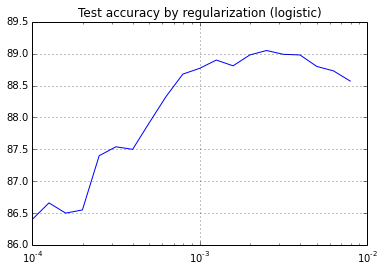

In [18]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

* 1-layer network model with L2 regulation(Regularizing with beta : not hardcoding)

In [19]:
batch_size = 128
hidden_node = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed / 입력.
    # at run time with a training minibatch. / training data는 minibatch를 실시간으로 먹이기 위해 placeholder를 쓴다.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_node]))
    biases1 = tf.Variable(tf.zeros([hidden_node]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_node, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    def forward_prop(inp):
        hidden_layer1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
        return tf.matmul(hidden_layer1, weights2) + biases2
    
    # Training computation.
    
    logits = forward_prop(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss = tf.reduce_mean(loss + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [20]:
# Test with beta = 0.0001
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. / 랜덤화된 training data안에 offset을 만든다.
    # Note: we could use better randomization across epochs. / (시간?!) 랜덤을 더 잘 사용.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # offset은 minibatch를 만들기 위해서..
    # Generate a minibatch. / minibatch를 만든다.
    batch_data = train_dataset[offset:(offset + batch_size), :] 
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch. / 사전 준비 세션을 말하는 어디에서 미니배치를 먹는지
    # The key of the dictionary is the placeholder node of the graph to be fed, / 사전의 포인트는 먹히기 위해 그래프의 플홀 노드이다.
    # and the value is the numpy array to feed to it. / 그리고 그 값은 넘피 배열이다.
    # tensorflow의 docs에서 session.run()에 대한 부분을 보면, feed_dict은 다음과 같이 설명되어 있다.
    # 
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 662.818176
Minibatch accuracy: 11.7%
Validation accuracy: 35.2%
Minibatch loss at step 500: 195.308762
Minibatch accuracy: 77.3%
Validation accuracy: 81.2%
Minibatch loss at step 1000: 118.649803
Minibatch accuracy: 78.9%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 68.517281
Minibatch accuracy: 79.7%
Validation accuracy: 83.7%
Minibatch loss at step 2000: 41.434418
Minibatch accuracy: 87.5%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 25.169493
Minibatch accuracy: 85.9%
Validation accuracy: 86.7%
Minibatch loss at step 3000: 15.492086
Minibatch accuracy: 89.8%
Validation accuracy: 87.2%
Test accuracy: 93.0%


Let's see test accuracy with beta

In [21]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
  with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

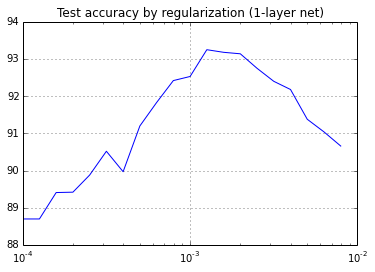

In [22]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

극도로 overfitting된 경우를 한번 해보자. training data를 몇몇 batch에서 제한시켜보자. 어떻게 될까?
(1-layer network applied to L2 regulation(beta : 0.0001))

---

In [23]:
batch_size = 128
hidden_node = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed / 입력.
    # at run time with a training minibatch. / training data는 minibatch를 실시간으로 먹이기 위해 placeholder를 쓴다.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_node]))
    biases1 = tf.Variable(tf.zeros([hidden_node]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_node, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    def forward_prop(inp):
        hidden_layer1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
        return tf.matmul(hidden_layer1, weights2) + biases2
    
    # Training computation.
    
    logits = forward_prop(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss = tf.reduce_mean(loss + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [27]:
# Test with beta = 0.0001
num_steps = 101
num_batches = 10

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. / 랜덤화된 training data안에 offset을 만든다.
    # Note: we could use better randomization across epochs. / (시간?!) 랜덤을 더 잘 사용.
    offset = (step * batch_size) % num_batches # offset은 minibatch를 만들기 위해서..
    # Generate a minibatch. / minibatch를 만든다.
    batch_data = train_dataset[offset:(offset + batch_size), :] 
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch. / 사전 준비 세션을 말하는 어디에서 미니배치를 먹는지
    # The key of the dictionary is the placeholder node of the graph to be fed, / 사전의 포인트는 먹히기 위해 그래프의 플홀 노드이다.
    # and the value is the numpy array to feed to it. / 그리고 그 값은 넘피 배열이다.
    # tensorflow의 docs에서 session.run()에 대한 부분을 보면, feed_dict은 다음과 같이 설명되어 있다.
    # 
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 646.448792
Minibatch accuracy: 9.4%
Validation accuracy: 34.7%
Minibatch loss at step 10: 312.049591
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 20: 308.943909
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 30: 305.869232
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 40: 302.825287
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 50: 299.811127
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 60: 296.827301
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 70: 293.873077
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 80: 290.948242
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 90: 288.052765
Minibatch accuracy: 100.0%
Validation accuracy: 64.8%
Minibatch loss at step 100: 285.185699
Minibatch accuracy: 100.0%
Valid

minibatch에 대한 학습은 100%에 도달하였으나, 다른 항목들을 보면 학습 결과가 형편없음을 알 수 있다.



---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

hidden layer에 Dropout을 도입한다. 기억할 사항 : dropout은 오로지 training할 때만 적용(evaluation X). TensorFlow는 `nn.dropout()`을 제공해준다. 다시 한번 말하지만, 오직 training할 때만 이 함수를 삽입해라.

질문 : 극도로 overfitting되는 경우, 어떤 일이 벌어지는지?

(1-layer network with L2 regulation. restrain the number of batch like above. Just apply dropout, and compare with above)
(L2 regulation 포함에 dropout 적용. 바로 위 problem 2와 동일한 조건에서 실행하여 결과를 비교해보자.)

---

In [28]:
batch_size = 128
hidden_node = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed / 입력.
    # at run time with a training minibatch. / training data는 minibatch를 실시간으로 먹이기 위해 placeholder를 쓴다.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_node]))
    biases1 = tf.Variable(tf.zeros([hidden_node]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_node, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    def forward_prop(inp):
        hidden_layer1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
        return tf.matmul(hidden_layer1, weights2) + biases2
    
    # Training computation.
    hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1)+biases1)
    dropout = tf.nn.dropout(hidden_layer1, 0.5) # apply dropout on hidden layer
    logits = tf.matmul(dropout, weights2) + biases2 # logits would be calculated with dropout instead of hidden_layer1
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss = tf.reduce_mean(loss + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [29]:
# Test with beta = 0.0001
num_steps = 101
num_batches = 10

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. / 랜덤화된 training data안에 offset을 만든다.
    # Note: we could use better randomization across epochs. / (시간?!) 랜덤을 더 잘 사용.
    offset = (step * batch_size) % num_batches # offset은 minibatch를 만들기 위해서..
    # Generate a minibatch. / minibatch를 만든다.
    batch_data = train_dataset[offset:(offset + batch_size), :] 
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch. / 사전 준비 세션을 말하는 어디에서 미니배치를 먹는지
    # The key of the dictionary is the placeholder node of the graph to be fed, / 사전의 포인트는 먹히기 위해 그래프의 플홀 노드이다.
    # and the value is the numpy array to feed to it. / 그리고 그 값은 넘피 배열이다.
    # tensorflow의 docs에서 session.run()에 대한 부분을 보면, feed_dict은 다음과 같이 설명되어 있다.
    # 
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 783.694702
Minibatch accuracy: 6.2%
Validation accuracy: 36.3%
Minibatch loss at step 10: 313.633545
Minibatch accuracy: 96.9%
Validation accuracy: 70.6%
Minibatch loss at step 20: 309.905975
Minibatch accuracy: 99.2%
Validation accuracy: 71.3%
Minibatch loss at step 30: 306.150299
Minibatch accuracy: 100.0%
Validation accuracy: 71.2%
Minibatch loss at step 40: 303.530029
Minibatch accuracy: 99.2%
Validation accuracy: 71.2%
Minibatch loss at step 50: 300.118134
Minibatch accuracy: 100.0%
Validation accuracy: 71.0%
Minibatch loss at step 60: 298.202759
Minibatch accuracy: 99.2%
Validation accuracy: 72.0%
Minibatch loss at step 70: 294.181915
Minibatch accuracy: 100.0%
Validation accuracy: 72.2%
Minibatch loss at step 80: 291.255890
Minibatch accuracy: 100.0%
Validation accuracy: 72.3%
Minibatch loss at step 90: 288.364044
Minibatch accuracy: 100.0%
Validation accuracy: 72.2%
Minibatch loss at step 100: 285.500885
Minibatch accuracy: 100.0%
Validatio

여전히 minibatch에 대해선 overfitting된 경향을 보이나, problem 2와는 다르게 99%로 감소하는 구간도 있고, 100%에 달성하기까지의 단계도 더 오래 걸린다. 무엇보다 validation, test accuracy가 향상되었다.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
multi-layer model을 이용해서 최고의 퍼포먼스를 만들어봐라. 지금까지는 97.1%의 test accuracy가 가장 높은 퍼포먼스이다.

multiple layer를 추가하는 것이 방법이 될 수 있다.

또 다른 방법으로는 learning rate decay를 적용시키는 것이다.
 
 ---


# First Trial

2-layer network with L2 generalization and dropout(only first layer). And also use learning rate decay(decay every 1000 steps with a base of 0.90).

In [42]:
batch_size = 128
hidden_node1 = 1024
hidden_node2 = 512

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed / 입력.
    # at run time with a training minibatch. / training data는 minibatch를 실시간으로 먹이기 위해 placeholder를 쓴다.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)  # count the number of steps taken.
  
    # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal(
            [image_size * image_size, hidden_node1], stddev=np.sqrt(2.0/(image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([hidden_node1]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_node1, hidden_node2], stddev=np.sqrt(2.0/hidden_node1)))
    biases2 = tf.Variable(tf.zeros([hidden_node2]))
    
    weights3 = tf.Variable(tf.truncated_normal([hidden_node2, num_labels], stddev=np.sqrt(2.0/hidden_node2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    
    def forward_prop(inp):
        h_layer1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
        h_layer2 = tf.nn.relu(tf.matmul(h_layer1, weights2)+biases2)
        return tf.matmul(h_layer2, weights3) + biases3
    
    # Training computation.
    hidden_layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1)+biases1)
    dropout = tf.nn.dropout(hidden_layer1, 0.5) # apply dropout on hidden layer
    hidden_layer2 = tf.nn.relu(tf.matmul(dropout, weights2)+biases2)
    logits = tf.matmul(hidden_layer2, weights3) + biases3 # logits would be calculated with dropout instead of hidden_layer1
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss = tf.reduce_mean(loss + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)+tf.nn.l2_loss(weights3)))
  
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.1, global_step, 4000, 0.90, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
    test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Number of steps = 3001, beta = 0.00011

In [43]:
# Test with beta = 0.00011
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized. / 랜덤화된 training data안에 offset을 만든다.
    # Note: we could use better randomization across epochs. / (시간?!) 랜덤을 더 잘 사용.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size) # offset은 minibatch를 만들기 위해서..
    # Generate a minibatch. / minibatch를 만든다.
    batch_data = train_dataset[offset:(offset + batch_size), :] 
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch. / 사전 준비 세션을 말하는 어디에서 미니배치를 먹는지
    # The key of the dictionary is the placeholder node of the graph to be fed, / 사전의 포인트는 먹히기 위해 그래프의 플홀 노드이다.
    # and the value is the numpy array to feed to it. / 그리고 그 값은 넘피 배열이다.
    # tensorflow의 docs에서 session.run()에 대한 부분을 보면, feed_dict은 다음과 같이 설명되어 있다.
    # 
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 0.00011}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.635016
Minibatch accuracy: 10.2%
Validation accuracy: 23.1%
Minibatch loss at step 500: 0.697492
Minibatch accuracy: 82.0%
Validation accuracy: 85.0%
Minibatch loss at step 1000: 0.723921
Minibatch accuracy: 81.2%
Validation accuracy: 85.9%
Minibatch loss at step 1500: 0.710466
Minibatch accuracy: 82.0%
Validation accuracy: 87.0%
Minibatch loss at step 2000: 0.575264
Minibatch accuracy: 85.2%
Validation accuracy: 87.9%
Minibatch loss at step 2500: 0.527446
Minibatch accuracy: 86.7%
Validation accuracy: 87.9%
Minibatch loss at step 3000: 0.673576
Minibatch accuracy: 86.7%
Validation accuracy: 88.3%
Minibatch loss at step 3500: 0.571718
Minibatch accuracy: 88.3%
Validation accuracy: 88.6%
Minibatch loss at step 4000: 0.546977
Minibatch accuracy: 85.9%
Validation accuracy: 88.9%
Minibatch loss at step 4500: 0.381349
Minibatch accuracy: 91.4%
Validation accuracy: 89.0%
Minibatch loss at step 5000: 0.454287
Minibatch accuracy: 89.8%
Validation accurac